# Trabalho #3 - Treinamento customizado

Nesse trabalho você vai treinar uma RNA para prever se um tumor é maligno ou benigno usando o conjunto de dados "Breast Cancer Dataset", disponível no UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)


Esse conjunto de dados foi obtido pelo Hospital da University de Wisconsin, Madison por: O. L. Mangasarian e W. H. Wolberge, "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

## Coloque o seu nome:

Nome: Wallace de Castro Galvão

## 1. Importar bibliotecas

Execute a célula abaixo para importar as principais bilbiotecas necessárias.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-12-04 21:59:59.503542: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 21:59:59.506708: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 21:59:59.515029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733349599.529278    3679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733349599.533607    3679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 21:59:59.549600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 2.  Carregar dados

Esse conjunto de dados possui 699 exemplos, sendo que cada exemplo é composto por 10 características ontidas por exames de células de tecidos que podem ser da classe de cancer maligno ou benigino.

As características de cada exemplo são as seguintes:

1. Número de identificação da amostra: id
2. Espessura do aglomerado: 1 - 10
3. Uniformidade do tamanho da célula: 1 - 10
4. Uniformidade da forma celular: 1 - 10
5. Adesão Marginal: 1 - 10
6. Tamanho de célula epitelial única: 1 - 10
7. Núcleos expostos: 1 - 10
8. Cromatina Suave: 1 - 10
9. Nucléos normais: 1 - 10
10. Mitoses: 1 - 10
11. Casse: 2 para benigno e 4 para maligno

Execute a célula abaixo para carregar o conjunto de dados e criar um DataFrame Pandas. Para facilitar o entendimento dos dados vamos definir explicitamente os nomes das colunas porque o arquivo CSV original não possui o cabeçalho com os nomes das colunas.

In [3]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "espessura", "un_tam_cel", "un_forma_cel", "adesao_marginal", "tam_cel_epit", "nucleos_exp", "cromatina", "nucleos_normais", "mitoses", "classe"]
df = pd.read_csv(data_file, names=col_names, header=None)

   8192/Unknown 0s 9us/step

Execute as duas células abaixo para visualizar os dados e verificar o número de exemplos.

In [4]:
df.head()

,id,espessura,un_tam_cel,un_forma_cel,adesao_marginal,tam_cel_epit,nucleos_exp,cromatina,nucleos_normais,mitoses,classe
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
print('Dimensão dos dados:', df.shape)

Dimensão dos dados: (699, 11)


## 3. Pré-processamento dos dados

Os dados precisam ser pré-processados para poderem ser utilzados por uma RNA.

As seguintes etapas devem ser realizadas no processamento:

1. Retirar a coluna da identificação da amostra ("id");
2. Eliminar dados que possuem valores "desconhecidos";
3. Transformar classes de índices 2 e 4 para 0 e 1, 0 é benigno e 1 é maligno;
4. Dividir dados nos conjuntos de treinamento e teste;
5. Separar coluna das classes (dados de saídas reais) das outras colunas (dados de entradas);
6. Normalizar os dados de entrada;
7. Conveter DataFrame Pandas para tf.Tensor.

### 3.1 Retirar coluna de identificação da amostra ("id")

Execute a célula baixo para realizar essa operação.

In [6]:
df.pop("id")
df.head()

,espessura,un_tam_cel,un_forma_cel,adesao_marginal,tam_cel_epit,nucleos_exp,cromatina,nucleos_normais,mitoses,classe
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


### 3.2 Eliminar dados "desconhecidos"

Se você inspecionar os dados vai verificar que existem valores "desconhecidos" na coluna de "nucleos_exp". Para verificar quais amostras possuem valores desconhecidos execute a célula abaixo.

In [7]:
df[df["nucleos_exp"] == '?']

,espessura,un_tam_cel,un_forma_cel,adesao_marginal,tam_cel_epit,nucleos_exp,cromatina,nucleos_normais,mitoses,classe
23,8,4,5,1,2,?,7,3,1,4
40,6,6,6,9,6,?,7,8,1,2
139,1,1,1,1,1,?,2,1,1,2
145,1,1,3,1,2,?,2,1,1,2
158,1,1,2,1,3,?,1,1,1,2
164,5,1,1,1,2,?,3,1,1,2
235,3,1,4,1,2,?,3,1,1,2
249,3,1,1,1,2,?,3,1,1,2
275,3,1,3,1,2,?,2,1,1,2
292,8,8,8,1,2,?,6,10,1,4


Deve-se eliminar as linhas que possuem dados desse tipo. Além disso, a coluna "nucleos_exp" não é uma coluna numérica e, portanto, deve ser convertida para valores numéricos. Execute a célula abaixo para realizar essas operações.

In [8]:
# Elimina linhas com dados desconhecidos na coluna "nucleos_exp"
df = df[df["nucleos_exp"] != '?' ]

# Converte coluna "nucleo_exp" para valores numéricos
df.nucleos_exp = pd.to_numeric(df.nucleos_exp)
df

,espessura,un_tam_cel,un_forma_cel,adesao_marginal,tam_cel_epit,nucleos_exp,cromatina,nucleos_normais,mitoses,classe
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,2
695,2,1,1,1,2,1,1,1,1,2
696,5,10,10,3,7,3,8,10,2,4
697,4,8,6,4,3,4,10,6,1,4


- Observe que o conjunto de dados agora tem 683 exemplos, ou seja, 16 exemplos foram retirados porque tinham valores "unknown".

### 3.3 Transformar código das classes de câncer

Primeiramente vamos verificar o número de exemplos de cada classe. Lembre que:

- Classe = 2 $\to$ câncer benigno
- Classe = 4 $\to$ câncer maligno

Observa-se que é importante fazer essa verificação porque se o número de exemplos das classes for muito desbalanceado temos que usar técnicas especiais para treinar a RNA, como já visto anteriormente.

Para visualizar o número de exemplos de cada classe vamos calcular e fazer o gráfico do histograma da coluna "classe".

<Axes: >

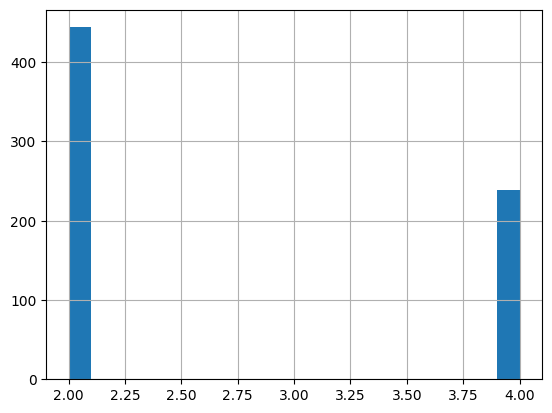

In [9]:
df['classe'].hist(bins=20)

Para poder modelar esse problema como um problema de classificão binária, que detecta se o tumor é maligno ou não, temos que alterar os códigos das classes para o seguinte:

- Câncer benigno (2.0) = 0
- Câncer maligno (4.0) = 1

In [10]:
df['classe'] = np.where(df['classe'] == 2, 0, 1)
df

,espessura,un_tam_cel,un_forma_cel,adesao_marginal,tam_cel_epit,nucleos_exp,cromatina,nucleos_normais,mitoses,classe
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


### Exercício #1: Dividir e embaralhar conjunto de dados

Vamos dividir o conjunto de dados em conjuntos de treinamento e teste. Como o número de amostras é pequeno, faremos a validação no conjunto de teste.

Nessa divisão vamos utilizar 80% dos dados como sendo de treinamento e 20% como sendo de teste/validação.

Para realizar essa divisão usaremos a função `train_test_split()` da biblioteca ScikitLearn. Observe que você deve usar essa função também para embaralhar aleatoriamente os dados.  

In [15]:
# Para você fazer: Dividir e embaralhar dados

# Importa função para dividir conjunto de dados
from sklearn.model_selection import train_test_split

# Realiza divisão dos dados
# Inclua seu código aqui
# Realiza divisão dos dados sem separar entrada e saída
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Verifica as dimensões completas dos conjuntos
print(f"Dimensão dos dados de treinamento: {train_data.shape}")
print(f"Dimensão dos dados de teste: {test_data.shape}")

Dimensão dos dados de treinamento: (546, 10)
Dimensão dos dados de teste: (137, 10)


**Saída esperada:**

    Dimensão dos dados de treinamento: (546, 10)
    Dimensão dos dados de teste: (137, 10)

### 3.4 Separar coluna das classes (saída desejada)

Devemos separar a coluna das classes dos conjuntos de treinamento e teste para criar as saídas desejadas de treinamento e teste.

In [16]:
train_Y = train.pop("classe")
test_Y = test.pop("classe")
train_Y

452    0
264    1
599    0
18     1
364    0
      ..
73     1
108    0
279    1
450    0
104    1
Name: classe, Length: 546, dtype: int64

Vamos calcular as estatísticas básicas das saídas dos conjuntos de treinamento e teste para verificar se ambos possuem a mesma distribuição.

In [17]:
print('Estatística das saídas de treinamento:\n', train_Y.describe())
print('\nEstatística das saídas de teste:\n', test_Y.describe())

Estatística das saídas de treinamento:
 count    546.000000
mean       0.331502
std        0.471185
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: classe, dtype: float64

Estatística das saídas de teste:
 count    137.000000
mean       0.423358
std        0.495904
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: classe, dtype: float64


### 3.5 Normalizar dados de entrada

Antes de normalizar os dados de entrada é importante calcular as suas estatísticas básicas. Os valores de média e desvio padrão das caracteríticas dos dados de entrada de treinamento serão usados para normalizar os dados de treinamento e de teste.

In [18]:
train_stats = train.describe()
train_stats = train_stats.transpose()
print(train_stats.shape)
train_stats

(9, 8)


,count,mean,std,min,25%,50%,75%,max
espessura,546.0,4.415751,2.762337,1.0,2.0,4.0,6.00,10.0
un_tam_cel,546.0,3.106227,3.056003,1.0,1.0,1.0,4.75,10.0
un_forma_cel,546.0,3.212454,3.035374,1.0,1.0,1.0,5.00,10.0
adesao_marginal,546.0,2.824176,2.857830,1.0,1.0,1.0,4.00,10.0
tam_cel_epit,546.0,3.184982,2.179267,1.0,2.0,2.0,4.00,10.0
nucleos_exp,546.0,3.468864,3.630647,1.0,1.0,1.0,5.00,10.0
cromatina,546.0,3.315018,2.383359,1.0,2.0,3.0,4.00,10.0
nucleos_normais,546.0,2.752747,2.949614,1.0,1.0,1.0,3.00,10.0
mitoses,546.0,1.553114,1.632783,1.0,1.0,1.0,1.00,10.0


### Exercícios #2: Normalizar dados de entrada

Os dados de entrada serão normalizados para terem média igual a zero e disvio padrão igual a 1. Assim, a normalizaçãp de cada coluna deve ser feita de acordo com a seguinte equação:

$$X_{norm,i} = \frac{(X_i - \mu_i)} {\sigma_i}$$

onde $X_i$ é a i-ésima coluna dos dados, $\mu_i$ é a média da i-ésima coluna, $\sigma_i$ é o desvio padrão da i-ésima coluna e $X_{norm,i}$ é a i-ésima coluna dos dados normalizada.

In [19]:
# Define função para normalizar as colunas
def normalizar_dados(df, stats):
    """
    Normaliza os dados de um DataFrame com base na média e desvio padrão fornecidos.
    
    Args:
        df (pd.DataFrame): Dados a serem normalizados.
        stats (pd.DataFrame): Estatísticas (média e desvio padrão) usadas para normalização.
        
    Returns:
        pd.DataFrame: Dados normalizados.
    """
    return (df - stats['mean']) / stats['std']

# Calcula estatísticas dos dados de treinamento
train_stats = train.describe().transpose()

# Normaliza dados de entrada de treinamento e teste
X_train_norm = normalizar_dados(train, train_stats)
X_test_norm = normalizar_dados(test, train_stats)

# Visualiza dados de entrada de treinamento normalizados
print("Dados de entrada de treinamento normalizados:")
print(X_train_norm.head())

Dados de entrada de treinamento normalizados:
     espessura  un_tam_cel  un_forma_cel  adesao_marginal  tam_cel_epit  \
452  -0.512519   -0.689210     -0.728890         0.061524     -0.543752   
264   0.935530    1.928589      0.259456         2.510934      3.127206   
599   0.211505   -0.361985      0.259456        -0.638308     -1.002622   
18    2.021567    1.274139      1.247802         1.111271      0.373987   
364  -0.874532   -0.689210     -0.728890        -0.638308     -0.543752   

     nucleos_exp  cromatina  nucleos_normais   mitoses  
452    -0.680007  -0.971326        -0.594229 -0.338755  
264    -0.129141   0.706978         0.083825  0.886147  
599    -0.680007  -0.971326        -0.594229 -0.338755  
18      1.798890   0.287402        -0.594229  0.273696  
364    -0.680007  -0.132174        -0.594229 -0.338755  


In [20]:
X_train_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
espessura,546.0,-8.946852e-17,1.0,-1.236544,-0.874532,-0.150507,0.573518,2.021567
un_tam_cel,546.0,2.277381e-17,1.0,-0.689210,-0.689210,-0.689210,0.537883,2.255814
un_forma_cel,546.0,-4.229421e-17,1.0,-0.728890,-0.728890,-0.728890,0.588905,2.236148
adesao_marginal,546.0,-9.597532e-17,1.0,-0.638308,-0.638308,-0.638308,0.411439,2.510934
tam_cel_epit,546.0,8.458842e-17,1.0,-1.002622,-0.543752,-0.543752,0.373987,3.127206
nucleos_exp,546.0,-1.952040e-17,1.0,-0.680007,-0.680007,-0.680007,0.421725,1.798890
cromatina,546.0,-1.073622e-16,1.0,-0.971326,-0.551750,-0.132174,0.287402,2.804858
nucleos_normais,546.0,1.301360e-17,1.0,-0.594229,-0.594229,-0.594229,0.083825,2.457017
mitoses,546.0,-1.138690e-17,1.0,-0.338755,-0.338755,-0.338755,-0.338755,5.173305


**Saída esperada:**

       count	        mean	std  	min  25% 50%	  75%	 max
       espessura	     546.0	  -2.373966e-17  	1.0	  -1.225570   -0.871516  -0.163409  0.544698  1.960912
       un_tam_cel	     546.0	-8.743515e-17	1.0	-0.706795	-0.706795	-0.706795	0.566836	2.158875
       un_forma_cel  	546.0	9.800870e-17	1.0	-0.746659	-0.746659	-0.746659	0.549607	2.169940|    
       adesao_marginal 	546.0	9.190857e-17	1.0	-0.658547	-0.658547	-0.658547	0.372715	2.435239
       tam_cel_epit     546.0	1.352195e-16	1.0	-0.998697	-0.563163	-0.563163	0.307905	2.921108
       nucleos_exp  	    546.0	-4.636096e-17	1.0	-0.695540	-0.695540	-0.695540	0.612569	1.782983
       cromatina        546.0	-3.700743e-17	1.0	-0.982966	-0.583636	-0.184306	0.215024	2.611003
       nucleos_normais   546.0	2.257047e-16	1.0	-0.620388	-0.620388	-0.620388	0.347417	2.283027
       mitoses	         546.0	-9.007853e-17	1.0	-0.352816	-0.352816	-0.352816	-0.352816	4.716589

### Exercício #3: Converter DataFrame para tf.Tensor

Para os dados poderem ser usados por uma RNA em um loop de treinamento customizado eles devem estar no forma de tensores do TensorFlow, assim, vamos converter os dados para tf.Tensor.

In [27]:
# Converte entradas para tf.Tensor
X_train = tf.convert_to_tensor(X_train_norm, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test_norm, dtype=tf.float32)

# Converte saídas para tf.Tensor e ajusta dimensões
Y_train = tf.convert_to_tensor(train_Y.values, dtype=tf.int32)
Y_test = tf.convert_to_tensor(test_Y.values, dtype=tf.int32)

# Ajusta as dimensões para serem compatíveis com as entradas e saídas de uma RNA
Y_train = tf.reshape(Y_train, (-1, 1))
Y_test = tf.reshape(Y_test, (-1, 1))

print('Dimensão dos dados de entrada de treinamemto:', X_train.shape)
print('Dimensão dos dados de entrada de teste:', X_test.shape)
print('Dimensão dos dados de saída de treinamemto:', Y_train.shape)
print('Dimensão dos dados de saída de teste:', Y_test.shape)

Dimensão dos dados de entrada de treinamemto: (546, 9)
Dimensão dos dados de entrada de teste: (137, 9)
Dimensão dos dados de saída de treinamemto: (546, 1)
Dimensão dos dados de saída de teste: (137, 1)


**Saída esperada:**

    Dimensão dos dados de entrada de treinamemto: (546, 9)
    Dimensão dos dados de entrada de teste: (137, 9)
    Dimensão dos dados de saída de treinamemto: (546, 1)
    Dimensão dos dados de saída de teste: (137, 1)

In [28]:
print(X_train[:10])
print(Y_train[:10])

tf.Tensor(
[[-0.5125193  -0.68920976 -0.7288901   0.06152366 -0.5437524  -0.68000674
  -0.9713261  -0.5942294  -0.33875504]
 [ 0.9355301   1.9285887   0.25945592  2.5109344   3.1272066  -0.12914075
   0.70697784  0.08382546  0.8861473 ]
 [ 0.21150538 -0.36198497  0.25945592 -0.6383079  -1.0026222  -0.68000674
  -0.9713261  -0.5942294  -0.33875504]
 [ 2.021567    1.2741392   1.247802    1.111271    0.37398735  1.7988902
   0.28740185 -0.5942294   0.27369612]
 [-0.8745317  -0.68920976 -0.7288901  -0.6383079  -0.5437524  -0.68000674
  -0.13217412 -0.5942294  -0.33875504]
 [-0.15050697 -0.68920976 -0.7288901  -0.6383079  -0.5437524  -0.68000674
  -0.5517501  -0.5942294  -0.33875504]
 [ 0.21150538 -0.68920976 -0.7288901  -0.6383079  -1.0026222  -0.68000674
  -0.9713261  -0.5942294  -0.33875504]
 [ 2.021567    2.2558136   2.236148    2.5109344  -0.08488252  1.7988902
   2.8048577   1.1009078  -0.33875504]
 [ 0.57351774 -0.03476015  0.25945592 -0.6383079   0.8328572  -0.40457374
  -0.13217412

**Saída esperada:**

    tf.Tensor(
    [[ 1.9609115   2.158875    1.8458735   0.02896096  1.6145062   0.4060258
      -0.18430609  0.67001873 -0.35281572]
     [-0.51746273 -0.70679533 -0.7466588  -0.658547   -0.56316274 -0.69553983
      -0.98296577 -0.62038773 -0.35281572]
     [-1.2255697  -0.70679533 -0.09852573 -0.658547   -0.56316274 -0.69553983
      -0.98296577 -0.62038773 -0.35281572]
     [-1.2255697  -0.70679533 -0.42259225 -0.658547   -0.56316274 -0.42014843
       0.21502376 -0.29778612 -0.35281572]
     [-0.8715162   0.5668359   1.1977404   1.0602229   0.30790484  1.7829828
       1.4130133   0.99262035 -0.35281572]
     [ 1.9609115   2.158875    1.1977404   1.7477309   1.6145062  -0.69553983
       2.611003    2.2830267   0.77371866]
     [-1.2255697  -0.70679533 -0.7466588  -0.658547   -0.9986965  -0.69553983
      -0.98296577  0.02481551 -0.35281572]
     [ 0.19064417 -0.06997974 -0.42259225  1.7477309   0.74343866  1.7829828
       1.8123431  -0.62038773  0.21045148]
     [ 1.9609115   0.24842808  0.54960734  0.37271494 -0.12762895  0.4060258
       1.4130133   0.02481551 -0.35281572]
     [ 0.19064417 -0.70679533 -0.7466588  -0.658547   -0.56316274 -0.69553983
      -0.18430609 -0.62038773 -0.35281572]], shape=(10, 9), dtype=float32)
    tf.Tensor(
    [[1]
     [0]
     [0]
     [0]
     [1]
     [1]
     [0]
     [1]
     [1]
     [0]], shape=(10, 1), dtype=int32)

## 4. Configuração e compilação da RNA

### Exercício #4: Configuração da RNA

Para realizar essa tarefa de classificação binária vamos utilizar uma RNA com 3 camadas tipo densa. Na célula abaixo configure a sua RNA usando os seguintes parâmetros:

- Primeira camada: 128 neurônios e função de ativação Relu;
- Segunda camada: 64 neurônios e função de ativação Relu;
- Camada de saída: 1 neurônio e função de ativação sigmoide.

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# Para você fazer: Configuração da RNA

# Inclua seu código aqui
#
# Configuração da RNA
rna = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Primeira camada
    Dense(64, activation='relu'),                                    # Segunda camada
    Dense(1, activation='sigmoid')                                   # Camada de saída
])
# Resumo da RNA
rna.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,601 (37.50 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 128)               1280      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                8256      
    _________________________________________________________________
    dense_2 (Dense)              (None, 1)                 65        
    =================================================================
    Total params: 9,601
    Trainable params: 9,601
    Non-trainable params: 0
    _________________________________________________________________

### Exercício #5: Definição do otimizador da RNA, função de custo e métrica

Na célula abaixo defina o otimizador, a função de custo e a métrica que serão usados no treinamento da RNA.

- Otimizador: Adam com taxa de aprendizado de 0.001;
- Função de custo: BinaryCrossentropy
- Métrica: Accuracy

Observa-se que deve-se usar as versões na forma de classes de todas essas funções.

In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
# Para você fazer: definir otimizador, função de custo e métrica

# Define objeto otimizador usando tf.keras.optimizer.Addam
# Inclua seu código aqui
otimizador = Adam(learning_rate=0.001)

# Define objeto função de custo usando tf.keras.losses.BinaryCrossentropy
# Inclua seu código aqui
funcao_custo = BinaryCrossentropy()

# Define objeto métrica usando tf.keras.metrics.BinaryAccuracy
# Inclua seu código aqui
metrica = BinaryAccuracy()

Vamos avaliar a RNA não treinada para termos uma base do resultado esperado do treinamento. Execute as células a seguir para realizar essa avaliação.

In [35]:
# Define o objeto da função de custo e da métrica
loss_object = funcao_custo  
metric_object = metrica     

# Calcula previsões da RNA não treinada
outputs = rna.predict(X_test)

# Calcula função de custo
loss_value = loss_object(y_true=Y_test, y_pred=outputs)
print("Custo antes do treinamento =", loss_value.numpy())

# Calcula métrica
accuracy = metric_object(y_true=Y_test, y_pred=outputs)
print("Métrica antes do treinamento =", accuracy.numpy())

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Custo antes do treinamento = 0.6803253
Métrica antes do treinamento = 0.60583943


**Saída esperada:**

    Custo antes do treinamento = 0.766273
    Métrica antes do treinamento = 0.16788322

/tmp/ipykernel_3679/3036150857.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_3679/3036150857.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


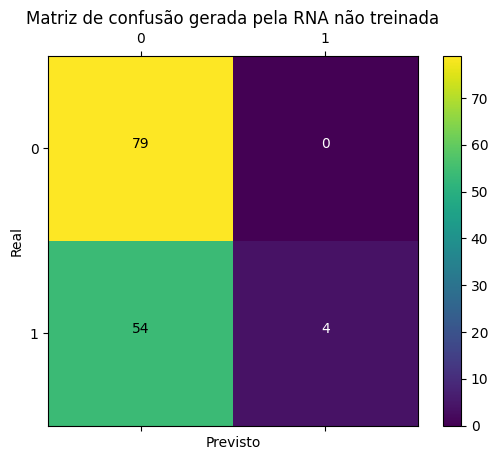

In [36]:
# Importa funções para calcula matriz e confusão
from sklearn.metrics import confusion_matrix
import itertools

# Define função para construir matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

plot_confusion_matrix(Y_test, tf.round(outputs), title='Matriz de confusão gerada pela RNA não treinada')

# 5. Treinamento da RNA

Para treinar essa RNA vamos criar um loop customizado usando a função `tf.GradientTape()`.


### Exercício #6: Criar função para calcular gradientes e atualizar parâmetros

Na célula abaixo crie um função que calcula o gradiente da função de custo em relação aos parâmetros da RNA e depois atualiza esses parâmetros usando o otimizador configurado anteriormente.

Para acessar os parâmetros de um modelo do TensorFlow basta usar `model.trainable_weights`.

In [37]:
# Para você fazer: criar função que calcula gradientes e atualiza parâmetros da RNA
@tf.function()
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    Função para calcular o gradinet e atualizar os parâmetros da RNA

    Argumentos:
        optimizer: otimizador configurado para atualizar os parâmetros
        loss_object: função de custo configurada anteriormente
        model: RNA que está sendo treinada
        x: tensor com os dados de entrada de treinamento
        y: saídas desejadas dos dados de treinamento

    Retorna:
        logits = saídas previstas pela RNA
        loss_value = valor da função de custo
    '''

    # Inclua seu código aqui
    with tf.GradientTape() as tape:
        # Calcula as saídas previstas pela RNA
        logits = model(x, training=True)
        # Calcula o valor da função de custo
        loss_value = loss_object(y_true=y, y_pred=logits)
    
    # Calcula os gradientes da função de custo em relação aos parâmetros da RNA
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Atualiza os parâmetros da RNA usando o otimizador
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return logits, loss_value

Execute a célula abaixo para testar a sua função `apply_gradient()`.

In [39]:
# Certifique-se de que o otimizador foi definido
optimizer = Adam(learning_rate=0.001)

# Cria nova RNA igual à configurada anteriormente
test_model = tf.keras.models.clone_model(rna)  # Clona a arquitetura para criar uma nova RNA
test_model.set_weights(rna.get_weights())     # Copia os pesos da RNA original

# Calcula saída prevista e função de custo usando a função apply_gradient
test_logits, test_loss = apply_gradient(optimizer, loss_object, test_model, X_test, Y_test)

# Exibe as primeiras saídas previstas e o valor da função de custo
print('Primeiras 5 saídas:', test_logits.numpy()[:5])
print('\nFunção de custo =', test_loss.numpy())

# Limpa as variáveis temporárias para evitar conflitos
del test_model
del test_logits
del test_loss


Primeiras 5 saídas: [[0.50162256]
 [0.37523556]
 [0.3955389 ]
 [0.3897107 ]
 [0.39998284]]

Função de custo = 0.6803254


**Saída esperada:**

    Primeiras 5 saídas: [[0.57383853]
     [0.53157353]
     [0.43801865]
     [0.47596937]
     [0.4938018 ]]
    
    Função de custo = 0.6647787

### Exercício #7: Cálculo da função de custo e métrica para os dados de validação

No final de cada época de treinamento, temos que validar a RNA no conjunto de dados de teste. Crie uma função que calcula a função de custo e a métrica para os dados validação.

In [40]:
@tf.function()
def perform_validation(model, x_val, y_val):
    """
    Função para calcular custo e métrica nos dados de validação.

    Argumentos:
        model: RNA sendo avaliada.
        x_val: Tensor com os dados de entrada de validação.
        y_val: Tensor com os dados de saída de validação.

    Retorna:
        val_loss: Valor da função de custo nos dados de validação.
        val_accuracy: Métrica de acurácia nos dados de validação.
    """
    # Calcula as saídas previstas para os dados de validação
    val_logits = model(x_val, training=False)

    # Calcula o custo para os dados de validação
    val_loss = loss_object(y_true=y_val, y_pred=val_logits)

    # Calcula as classes previstas (arredondando os valores)
    val_predictions = tf.round(val_logits)

    # Calcula a métrica de acurácia
    val_accuracy = metric_object(y_true=y_val, y_pred=val_predictions)

    return val_loss, val_accuracy


Execute a célula abaixo para testar a sua função `perform_validation()`.

In [41]:
val_loss, val_accuracy = perform_validation(rna, X_test, Y_test)

print('Função de custo para os dados de teste =', val_loss.numpy())
print('Exatidão para os dados de teste =', val_accuracy.numpy())

Função de custo para os dados de teste = 0.6803254
Exatidão para os dados de teste = 0.60583943


**Saída esperada:**

    Função de custo para os dados de teste = 0.7662731
    Exatidão para os dados de teste = 0.16788322

### Exercício #8: Loop e treinamento customizado

Usando a função `apply_gradient()` vamos criar um loop de treinamemto customizado. Utilize 1000 épocas de treinamento.


In [44]:
# Recria o otimizador
optimizer = Adam(learning_rate=0.001)

# Define número de épocas
num_epocas = 1000

# Loop de treinamento
for i in range(num_epocas):
    # Calcula gradientes e atualiza parâmetros da RNA
    logits, loss_value = apply_gradient(optimizer, loss_object, rna, X_train, Y_train)
    
    # Calcula métrica para dados de treinamento
    accuracy = metric_object(y_true=Y_train, y_pred=tf.round(logits))
    
    # Calcula função de custo e métrica para dados de validação
    val_loss, val_accuracy = perform_validation(rna, X_test, Y_test)
    
    # Imprime resultado da função de custo e métrica da época
    if i % 100 == 0:
        print('Época:', i, '-', 
              'custo =', loss_value.numpy(), 
              '-', 'exatidão =', accuracy.numpy(), 
              '-', 'custo_val =', val_loss.numpy(), 
              '-', 'val_exatidão =', val_accuracy.numpy())

# Imprime resultado final
print('\nCusto final =', loss_value.numpy())
print('Exatidão final =', accuracy.numpy())
print('\nCusto final de validação =', val_loss.numpy())
print('Exatidão final de validação =', val_accuracy.numpy())


Época: 0 - custo = 0.6587713 - exatidão = 0.6398538 - custo_val = 0.6215699 - val_exatidão = 0.64500403
Época: 100 - custo = 0.0645313 - exatidão = 0.9642188 - custo_val = 0.0595026 - val_exatidão = 0.9642318
Época: 200 - custo = 0.04603693 - exatidão = 0.97128415 - custo_val = 0.06027773 - val_exatidão = 0.9712837
Época: 300 - custo = 0.02414892 - exatidão = 0.9760333 - custo_val = 0.06940282 - val_exatidão = 0.97603464
Época: 400 - custo = 0.010032524 - exatidão = 0.9801199 - custo_val = 0.08283325 - val_exatidão = 0.9801189
Época: 500 - custo = 0.004392894 - exatidão = 0.9831141 - custo_val = 0.09561196 - val_exatidão = 0.9831121
Época: 600 - custo = 0.002266272 - exatidão = 0.9851908 - custo_val = 0.10730594 - val_exatidão = 0.9851885
Época: 700 - custo = 0.0013396542 - exatidão = 0.98667556 - custo_val = 0.11759516 - val_exatidão = 0.9866731
Época: 800 - custo = 0.000859003 - exatidão = 0.9877898 - custo_val = 0.12715006 - val_exatidão = 0.9877874
Época: 900 - custo = 0.000564494 

**Saída esperada:**

    Época: 0 - custo = 0.68436486 - exatidão = 0.34634146 - custo_val = 0.6501663 - val_exatidão = 0.3448276
    Época: 100 - custo = 0.058527242 - exatidão = 0.9515191 - custo_val = 0.080492094 - val_exatidão = 0.9515428
    Época: 200 - custo = 0.03760329 - exatidão = 0.96556544 - custo_val = 0.07935773 - val_exatidão = 0.9655706
    Época: 300 - custo = 0.018621787 - exatidão = 0.9716702 - custo_val = 0.09142268 - val_exatidão = 0.97165996
    Época: 400 - custo = 0.008029577 - exatidão = 0.9759616 - custo_val = 0.11785624 - val_exatidão = 0.97595173
    Época: 500 - custo = 0.0036735435 - exatidão = 0.9789992 - custo_val = 0.14663258 - val_exatidão = 0.9789901
    Época: 600 - custo = 0.0019131048 - exatidão = 0.9810311 - custo_val = 0.17128268 - val_exatidão = 0.98102283
    Época: 700 - custo = 0.0011265007 - exatidão = 0.9824835 - custo_val = 0.19244863 - val_exatidão = 0.982476
    Época: 800 - custo = 0.00072901906 - exatidão = 0.983407 - custo_val = 0.21075746 - val_exatidão = 0.9833984
    Época: 900 - custo = 0.0005036661 - exatidão = 0.984111 - custo_val = 0.2269108 - val_exatidão = 0.98410314
    
    Custo final = 0.0003456268
    Exatidão final= 0.98466927

    Custo final de validação = 0.24358612
    Exatidão final de validação = 0.98466206

## 7. Avaliação e teste da RNA

### Exercício #9: Cálculo da função de custo e métrica para os dados de teste

Na célula abaixo calcule a função de custo e a métrica para os dados de teste.

In [45]:
# Calcula saída prevista para os dados de teste
outputs_test = rna(X_test, training=False)

# Calcula função de custo para os dados de teste
loss_value_test = loss_object(y_true=Y_test, y_pred=outputs_test)

# Calcula métrica para os dados de teste
metric_value_test = metric_object(y_true=Y_test, y_pred=tf.round(outputs_test))

# Exibe os resultados
print("Custo =", loss_value_test.numpy())
print("Exatidão =", metric_value_test.numpy())

Custo = 0.1419413
Exatidão = 0.9893401


**Saída esperada:**

    Custo = 0.24358612
    Exatidão = 0.9846549

Execute a célula abaixo para calcular a matriz de confusão para a RNA treinada.

/tmp/ipykernel_3679/3036150857.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_3679/3036150857.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


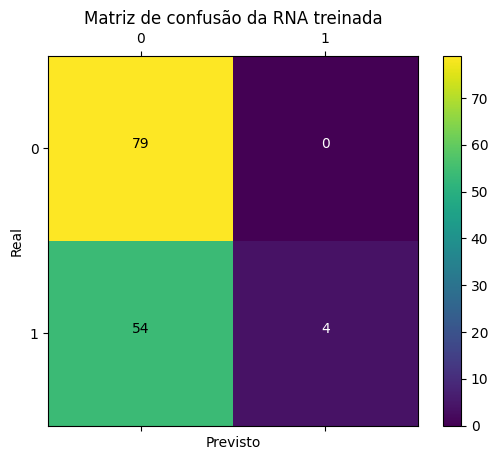

In [46]:
plot_confusion_matrix(Y_test, tf.round(outputs), title='Matriz de confusão da RNA treinada')

- Observa-se que o resultado da RNA é bastante satisfatório, sendo que apenas algumas amostras são classificadas erradas.

- Cerca de 96% das amostra são classificadas corretamente.